In [1]:
import csv
import re
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
import pandas as pd

# from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
import seaborn

plt.style.context("seaborn-whitegrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [38]:
genes = ['VTN', 'SEBOX']
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/all_data_by_genes.txt'
df = pd.read_csv(f, sep='\t')
df = df[df['Gene Symbol'].isin(genes)].drop(['Locus ID', 'Cytoband'], axis=1).set_index('Gene Symbol')
df.head()

,HTMCP-03-06-02256,HTMCP-03-06-02332,HTMCP-03-06-02414,HTMCP-03-06-02435,HTMCP-03-06-02261,HTMCP-03-06-02175,HTMCP-03-06-02098,HTMCP-03-06-02216,HTMCP-03-06-02155,HTMCP-03-06-02057,...,HTMCP-03-06-02176,HTMCP-03-06-02174,HTMCP-03-06-02239,HTMCP-03-06-02354,HTMCP-03-06-02259,HTMCP-03-06-02180,HTMCP-03-06-02344,HTMCP-03-06-02213,HTMCP-03-06-02179,HTMCP-03-06-02001
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
SEBOX,-0.006,-0.044,0.298,0.072,0.03,0.057,-0.544,0.021,-0.031,-0.018,...,-0.015,0.026,-0.014,0.025,0.122,0.089,-0.451,-0.001,0.001,-0.009
VTN,-0.006,-0.044,0.298,0.072,0.03,0.057,-0.544,0.021,-0.031,-0.018,...,-0.015,0.026,-0.014,0.025,0.122,0.089,-0.451,-0.001,0.001,-0.009


In [39]:
master_table = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_Cervical_Master_Patient_Table_V4_20190703.xlsx'
master = pd.read_excel(master_table, sep='\t', index_col='Patient')
master = master[master.Cohort == 'Discovery']

master = master[['HPV clade']].T
master.head(2)

Patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447
HPV clade,A9,A9,A9,A7,Other,Other,A9,A7,A9,A9,...,A9,A9,A7,A9,A7,A9,A9,A7,A7,A7


In [57]:
dfm = pd.concat([master, df], sort=False).T
dfm = dfm.rename(columns={'SEBOX':'SEBOX_cn', 'VTN':'VTN_cn'})
dfm.head()

,HPV clade,SEBOX_cn,VTN_cn
HTMCP-03-06-02001,A9,-0.009,-0.009
HTMCP-03-06-02002,A9,-0.008,-0.008
HTMCP-03-06-02003,A9,-0.021,-0.021
HTMCP-03-06-02006,A7,-0.245,-0.245
HTMCP-03-06-02008,Other,-0.009,-0.009


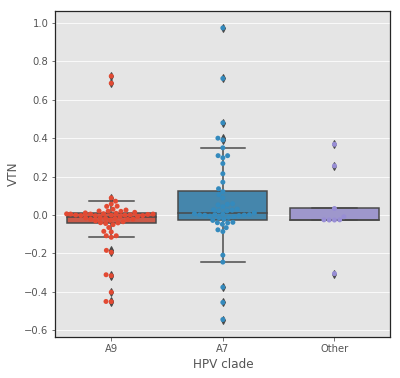

In [50]:
# dfm = dfm.head()
f, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(dfm['HPV clade'], dfm['VTN'].astype(float), ax=ax)
sns.swarmplot(dfm['HPV clade'], dfm['VTN'].astype(float), ax=ax)
# sns.scatterplot(data=dfm, x='HPV clade', y='VTN')
# ax.set_yscale('log')
# ax.set_ylim(-0.3, 1)

In [58]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/118_patient_rpkm.csv'
expr = pd.read_csv(f, index_col='gene').T
expr = expr[['VTN', 'SEBOX']]
expr = expr.rename(columns={'SEBOX':'SEBOX_rpkm', 'VTN':'VTN_rpkm'})
expr.shape
expr.head(2)

(118, 2)

gene,VTN_rpkm,SEBOX_rpkm
HTMCP-03-06-02001,0.0574,0.0642
HTMCP-03-06-02002,0.0836,0.0766


In [74]:
dff = pd.merge(dfm, expr, left_index=True, right_index=True)
dff.head()

,HPV clade,SEBOX_cn,VTN_cn,VTN_rpkm,SEBOX_rpkm
HTMCP-03-06-02001,A9,-0.009,-0.009,0.0574,0.0642
HTMCP-03-06-02002,A9,-0.008,-0.008,0.0836,0.0766
HTMCP-03-06-02003,A9,-0.021,-0.021,0.3994,0.4057
HTMCP-03-06-02006,A7,-0.245,-0.245,0.0763,0.0730
HTMCP-03-06-02008,Other,-0.009,-0.009,0.1232,0.0726


In [78]:
dff['VTN_cn'] = dff['VTN_cn'].astype(float)
dff['SEBOX_cn'] = dff['SEBOX_cn'].astype(float)

In [79]:
dff.describe()

,SEBOX_cn,VTN_cn,VTN_rpkm,SEBOX_rpkm
count,118.000000,118.000000,118.000000,118.000000
mean,0.018729,0.018729,1.463561,1.465764
std,0.218142,0.218142,6.642578,6.705326
min,-0.544000,-0.544000,0.000000,0.000000
25%,-0.037250,-0.037250,0.086775,0.076300
50%,-0.001000,-0.001000,0.150150,0.145250
75%,0.033250,0.033250,0.292200,0.271750
max,0.974000,0.974000,58.128800,58.686200


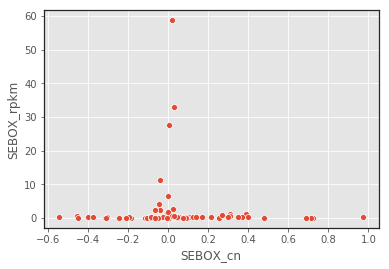

In [80]:
sns.scatterplot(data=dff, x='SEBOX_cn', y='SEBOX_rpkm')
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/SEBOX_cn_expression_20190709.png'
plt.savefig(of, dpi=150)

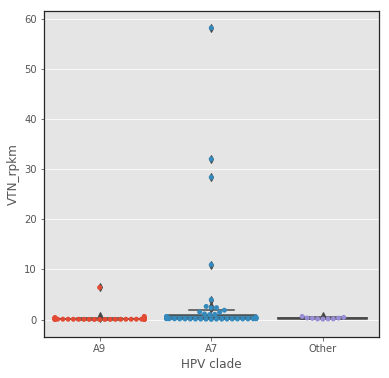

In [81]:
f, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data =dff, x='HPV clade', y='VTN_rpkm', ax=ax)
sns.swarmplot(data=dff, x='HPV clade', y='VTN_rpkm', ax=ax)
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/VTN_expression_20190709.png'
plt.savefig(of, dpi=150)

In [101]:
outliers = dff[dff.VTN_rpkm > 1].index

In [155]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/integration/hpv_integration_events_extended_from_Emma_20190708.txt'
df = pd.read_csv(f, sep='\t')
df.head()

,chr,start,end,event,sample,length,closest.gene,tss.dist
0,1,9155196,9158547,HTMCP-03-06-02328.HPV_68.1_9155196,HTMCP-03-06-02328.HPV_68,3351,SLC2A5,25309
1,1,9155196,9155489,HTMCP-03-06-02326.HPV_68.1_9155196,HTMCP-03-06-02326.HPV_68,293,SLC2A5,25309
2,1,17268994,17343229,HTMCP-03-06-02175.HPV_58.1_17268994,HTMCP-03-06-02175.HPV_58,74235,MFAP2,0
3,1,19357257,19357257,HTMCP-03-06-02411.HPV_16.1_19357257,HTMCP-03-06-02411.HPV_16,0,IFFO2,74430
4,1,22222804,22275462,HTMCP-03-06-02441.HPV_18.1_22222804,HTMCP-03-06-02441.HPV_18,52658,HSPG2,0


In [156]:
dfx = df.event.str.split('.', expand=True)
# dfx.columns = ['patient', 'hpv', 'integrate_site']
df['patient'] = dfx[0]
df['hpv'] = dfx[1]
df['chr'] = df['chr'].replace({'X':23}).astype(int)
df['start'] = df.start -10000
df['end'] = df.end + 10000
df = df.sort_values(['chr', 'start', 'end'])
df.drop(['event', 'sample'], axis=1, inplace=True)

In [157]:
df.dtypes

chr              int64
start            int64
end              int64
length           int64
closest.gene    object
tss.dist         int64
patient         object
hpv             object
dtype: object

In [138]:
df.length.max()
df.head()

408755

,chr,start,end,length,closest.gene,tss.dist,patient,hpv
253,23.0,11575288,11575288,0,ARHGAP6,108532,HTMCP-03-06-02411,HPV_16
254,23.0,53154732,53154732,0,TSPYL2,43190,HTMCP-03-06-02411,HPV_16
255,23.0,53170876,53170876,0,TSPYL2,59334,HTMCP-03-06-02240,HPV_16
256,23.0,87925234,87925234,0,CPXCR1,76990,HTMCP-03-06-02332,HPV_16
257,23.0,97127953,97127953,0,RPA4,989046,HTMCP-03-06-02442,HPV_18


In [158]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/integration_events.txt.sorted'
df.to_csv(of, index=False, header=False, sep='\t')

In [159]:
df.head()

,chr,start,end,length,closest.gene,tss.dist,patient,hpv
1,1,9145196,9165489,293,SLC2A5,25309,HTMCP-03-06-02326,HPV_68
0,1,9145196,9168547,3351,SLC2A5,25309,HTMCP-03-06-02328,HPV_68
2,1,17258994,17353229,74235,MFAP2,0,HTMCP-03-06-02175,HPV_58
3,1,19347257,19367257,0,IFFO2,74430,HTMCP-03-06-02411,HPV_16
4,1,22212804,22285462,52658,HSPG2,0,HTMCP-03-06-02441,HPV_18
